In [1]:
# show plots in notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Preparação dos dados para análise

Dados correspondentes a *Golden (USD)*

In [2]:
df = pd.read_csv('./data/WGC-GOLD_DAILY_USD.csv')
df.columns = ['date', 'gold']

# Combinação dos dados
Após a união de dados financeiros de ouro e bitcoin, utilizando a data como critério de união, podemos considerar que teremos os mesmos momentos históricos para análise de séries temporais.

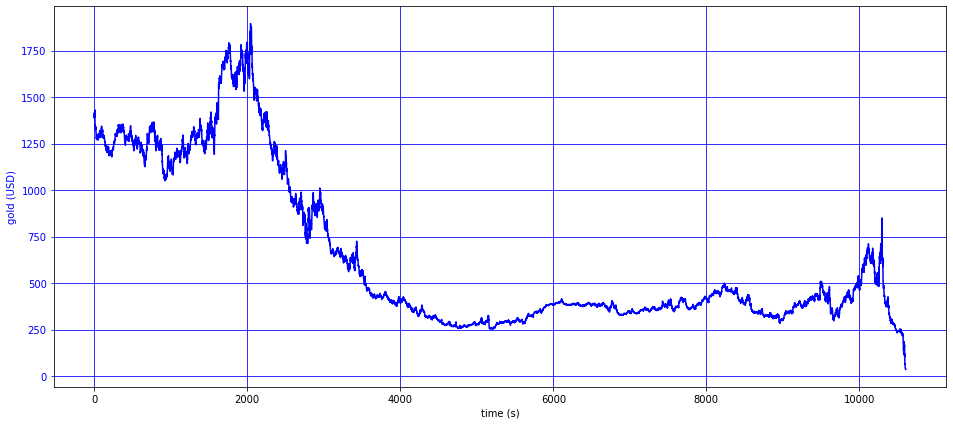

In [4]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(df.index, df['gold'], 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('gold (USD)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(color='b')

# ax2 = ax1.twinx()
# ax2.plot(df.index, df['bitcoin'], 'r-')
# ax2.set_ylabel('bitcoin (USD)', color='r')
# ax2.tick_params('y', colors='r')
# ax2.grid(color='r')
# fig.tight_layout()
# plt.title('Gold vs Bitcoin price')
plt.show()

In [5]:
def create_lag_series(time_series, num_series=10, lag_step=100):
    """
    Conceito de Takens Embedding Theorem
    :param []     time_series : uma serie temporal
    :param number lag_size    : tamanho do atraso, também conhecido como tau
    :param number num_series  : número de séries a serem criadas, sendo o indice Zero a serie original
    :returns: Lista de series com atrasos
    """
    series = []
    tail_size = (num_series-1) * lag_step
    for i in range(num_series):
        s = np.roll(time_series, -i*lag_step)
        series.append(s[:-tail_size])
    return series

In [6]:
serie = df['gold'].tolist()
lag_step = 1000
num_series = 10
series = create_lag_series(serie, num_series=num_series, lag_step=lag_step)

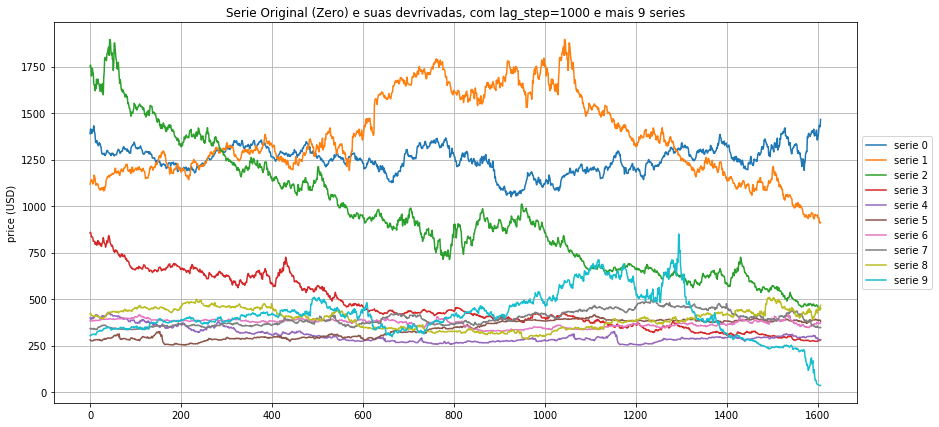

In [7]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)
for i in range(len(series)):
    ax1.plot(series[i], label='serie {}'.format(i))
# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Serie Original (Zero) e suas devrivadas, com lag_step={} e mais {} series'.format(lag_step, (num_series-1)))
ax1.set_ylabel('price (USD)')
ax1.grid()
plt.show()

In [94]:
def heaviside_check(value):
    return 1 if value > 0 else 0

def correlation(series, r, num_values=1000):
    total_sum = 0
    for i in range(len(series)):
        for j in range(len(series)):
            tmp_arr = series[:num_values,i]-series[:num_values,j]
            tmp_arr = np.power(tmp_arr, 2)
            tmp_arr = np.sum(tmp_arr)
            tmp_arr = np.sqrt(tmp_arr)
            total_sum += heaviside_check(r-tmp_arr)
    return (2/float((num_values*(num_values-1))))+total_sum

In [ ]:
num_values = 100
r = np.std(series[0,:num_values])
c = correlation(np.array(series), r, num_values=num_values)

In [8]:
# %load GP.py
# https://github.com/notsebastiano/GP_algorithm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def td_embedding(timeseries,emb,tau):
    '''
    Time delay embedding of timeseries of scalars
    Args:
        timeseries: array of scalars
        emb: (int) embedding dimension
        tau = (int) time delay between values in phase space reconstruction
    Returns:
        array of embedded vectors:
        [x[i],x[i+tau],x[i+2*tau],...,x[i + (m-1)*tau]]
    '''
    indexes = np.arange(0,emb,1)*tau
    return np.array([timeseries[indexes +i] for i in range(len(timeseries)-(emb-1)*tau)])


def logarithmic_r(min_n, max_n, factor):
    '''
    Creates array of values distributed such as log(values) is an array of
    evenly spaced (space between values = log(factor)) values between log(min_n) and log(max_n)
    Args:
        arg1: min_n: minimum value
        arg2: max_n: maximum value ( > arg1 )
        factor: log(factor) is the space between values
    Returns:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
    '''

    if max_n <= min_n:
        raise ValueError("arg1 has to be < arg2")
    if factor <= 1:
        raise ValueError("factor(arg3) has to be > 1")
    max_i = int(np.floor(np.log(1.0 * max_n / min_n) / np.log(factor)))
    return np.array([min_n * (factor ** i) for i in range(max_i + 1)])


def grassberg_procaccia(timeseries,emb_dim,time_delay,plot = None):
    '''
    Implementation of the Gassberger-Procaccia algorithm to estimate the
    correlation dimension of a set of points in an m-dimensional space.
    This code takes in input a timeseries of scalar values and the embedding dimension + time delay
    necessary to perform a time-delay embedding in phase space to reconstruct the attractor
    Args:
        timeseries: array of scalars
        emb_dim: (int) embedding dimension
        time_delay = (int) time delay between values in phase space reconstruction
    Kwargs:
        plot: if set to True: plots the logarithm of the correlation
        sums against the logarithm of the set of values of r considered in the algorithm
    r is the scaling factor, it tells the threshold distance between points. if we have a plateau
    of local slopes means that we are in a scaling range.
    Returns:
        Correlation dimension (scalar)
    '''
    data_std = np.std(timeseries)
    orbit = td_embedding(timeseries, emb_dim, time_delay)
    
    n = orbit.shape[0] # num rows
    r_vals = logarithmic_r(0.1 * data_std, 0.7 * data_std, 1.03)
    distances = np.zeros(shape=(n,n))
    r_matrix_base = np.zeros(shape=(n,n))

    for i in range(n):
        for j in range(i,n):
            distances[i][j] = np.linalg.norm(orbit[i]-orbit[j])
            r_matrix_base[i][j] = 1

    C_r = []
    for r in r_vals:
        r_matrix = r_matrix_base*r
        heavi_matrix = np.heaviside( r_matrix - distances, 0)
        try:
            corr_sum = (2/float(n*(n-1)))*np.sum(heavi_matrix)
        except ZeroDivisionError as ex:
            corr_sum = 0
        C_r.append(corr_sum)

    #strong assumption: the log-log plot is assumed to be a smooth, monotonic function,
    #hence the slope in the scaling region should be the maximum gradient ( in this case
    #is taken as the mean of the last five maximum gradients as they are calculated for every point )

    C_r = np.log2(C_r)
    r_vals_log = np.log2(r_vals)
    gradients = np.gradient(C_r, r_vals_log)
    gradients.sort()
    D = np.mean(gradients[-5:])

    if plot:
        plt.plot(r_vals_log,C_r)
        plt.xlabel('Correlation (log2)')
        plt.ylabel('r values (log2)')
        plt.show()
    
    return D, r_vals

In [ ]:
serie = np.array(serie)
_, r_vals = grassberg_procaccia(serie,emb_dim=3,time_delay=100, plot=True)

In [120]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

def create_time_series_lorenz(dt, num_steps, s=10, r=28, b=2.667):
    # Need one more for the initial values
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    # Set initial values
    xs[0], ys[0], zs[0] = (0., 1., 1.05)

    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], s=s, r=r, b=b)
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
    return xs, ys, zs

In [121]:
dt = 0.01
num_steps = 10000
xs, ys, zs = create_time_series_lorenz(dt, num_steps, s=10, r=28, b=2.667)

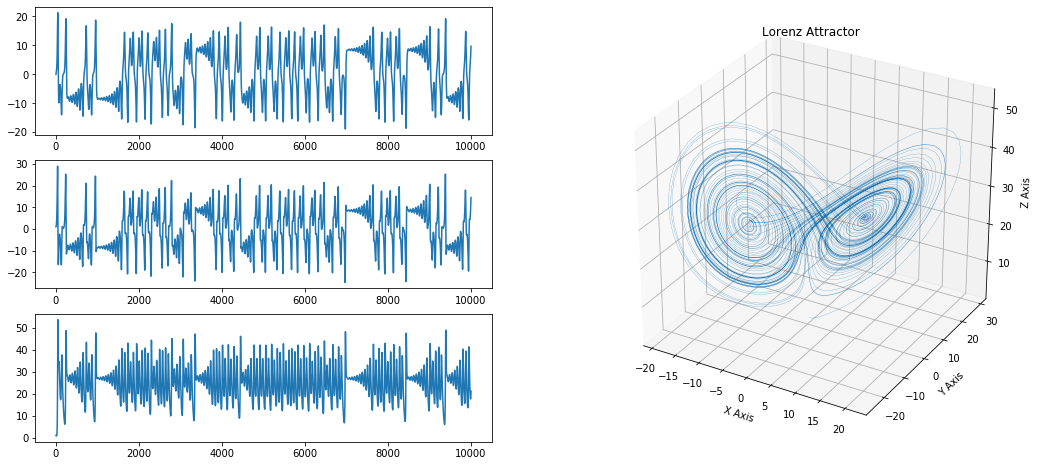

In [122]:
# Plot
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,3)
ax3 = fig.add_subplot(3,2,5)
ax1.plot(xs)
ax2.plot(ys)
ax3.plot(zs)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(xs, ys, zs, lw=0.2)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

In [123]:
serie = df['gold'].tolist()
serie = serie[:num_steps]
lag_step = 100
num_series = 10
series = create_lag_series(serie, num_series=num_series, lag_step=lag_step)
series = np.array(series)

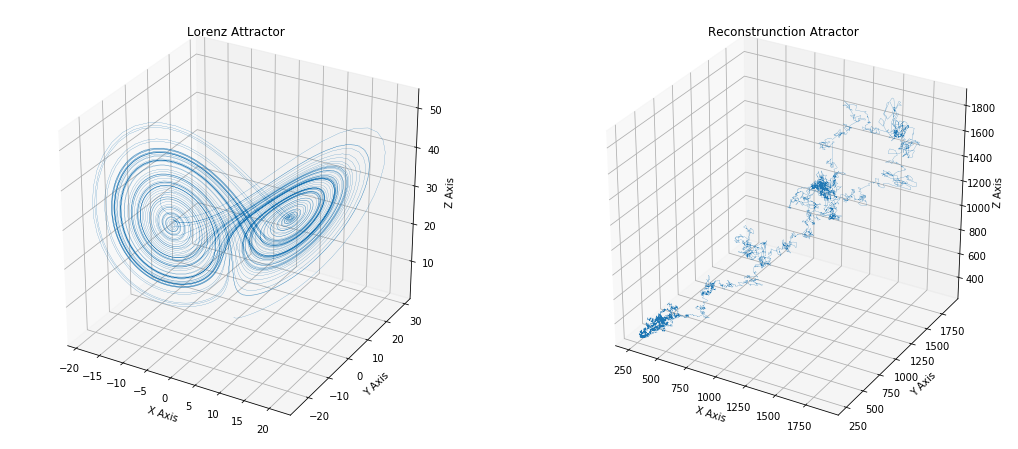

In [124]:
# Plot
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.plot(xs, ys, zs, lw=0.2)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("Lorenz Attractor")

ax2.plot(series[0], series[1], series[2], lw=0.2)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis")
ax2.set_title("Reconstrunction Atractor")
plt.show()

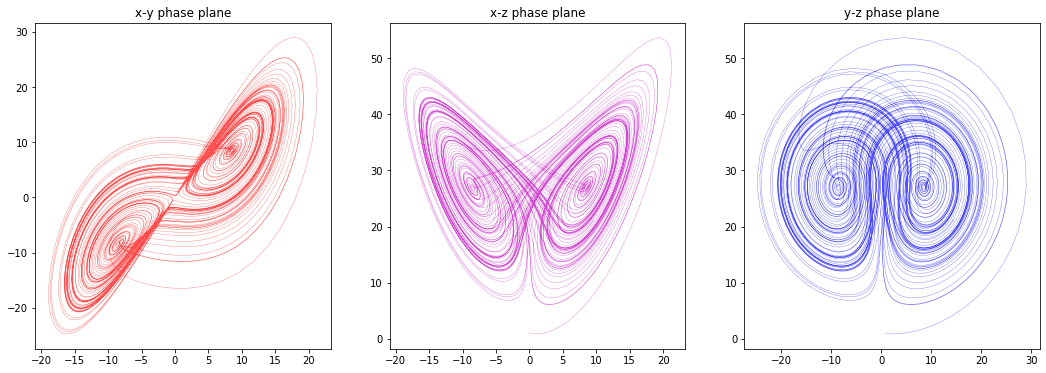

In [125]:
# now plot two-dimensional cuts of the three-dimensional phase space
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# plot the x values vs the y values
ax1.plot(xs, ys, color='r', alpha=0.7, linewidth=0.3)
ax1.set_title('x-y phase plane')

# plot the x values vs the z values
ax2.plot(xs, zs, color='m', alpha=0.7, linewidth=0.3)
ax2.set_title('x-z phase plane')

# plot the y values vs the z values
ax3.plot(ys, zs, color='b', alpha=0.7, linewidth=0.3)
ax3.set_title('y-z phase plane')

#fig.savefig('{}/lorenz-attractor-phase-plane.png'.format('images'), dpi=180, bbox_inches='tight')
plt.show()

In [126]:
xs, ys, zs = series[0], series[1], series[2]

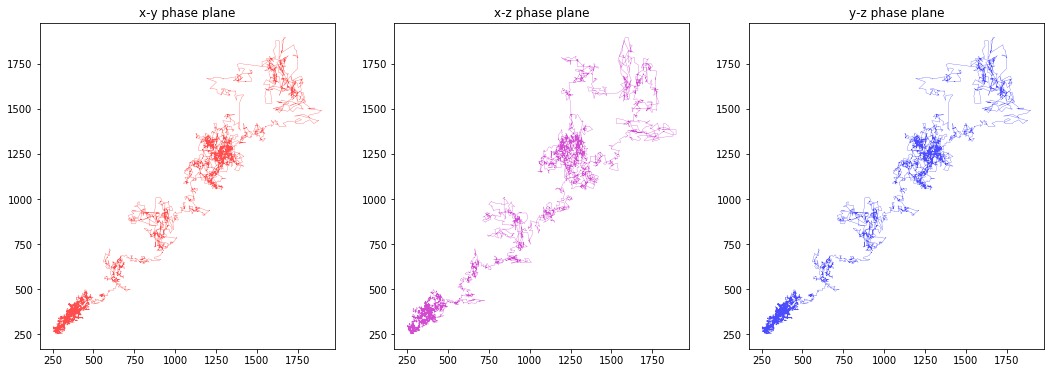

In [127]:
# now plot two-dimensional cuts of the three-dimensional phase space
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# plot the x values vs the y values
ax1.plot(xs, ys, color='r', alpha=0.7, linewidth=0.3)
ax1.set_title('x-y phase plane')

# plot the x values vs the z values
ax2.plot(xs, zs, color='m', alpha=0.7, linewidth=0.3)
ax2.set_title('x-z phase plane')

# plot the y values vs the z values
ax3.plot(ys, zs, color='b', alpha=0.7, linewidth=0.3)
ax3.set_title('y-z phase plane')

#fig.savefig('{}/lorenz-attractor-phase-plane.png'.format('images'), dpi=180, bbox_inches='tight')
plt.show()

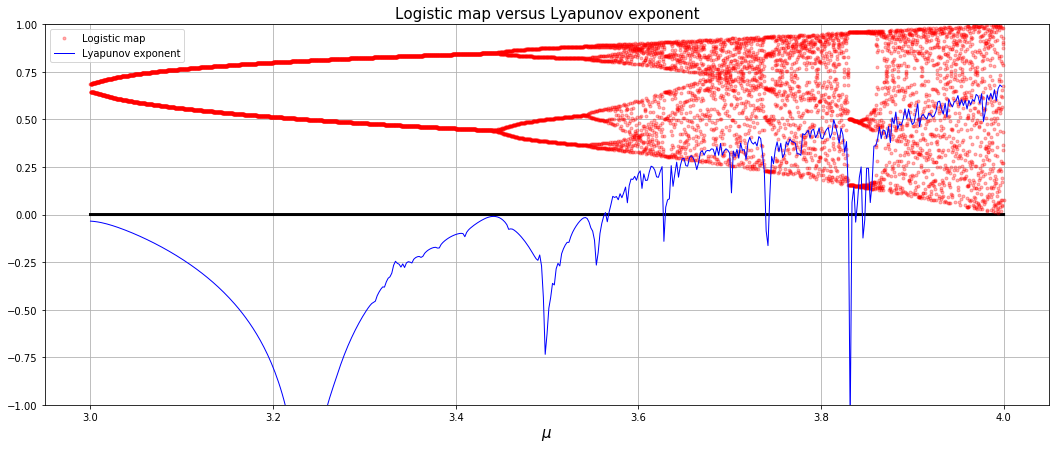

In [156]:
num_points = num_steps
result = []
lambdas = []
maps = []
xmin, xmax = 3, 4
mult = (xmax - xmin) * num_points

mu_values = np.arange(xmin, xmax, 20/num_points)

for r in mu_values:
    x = 0.1
    result = []
    for t in range(100):
        x = r * x * (1 - x)
        result.append(np.log(abs(r - 2*r*x)))
    lambdas.append(np.mean(result))
    # Ignore first 100 iterates.
    for t in range(20):
        x = r * x * (1 - x)
        maps.append(x)

fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)

xticks = np.linspace(xmin, xmax, mult)
zero = [0] * mult
ax1.plot(xticks, zero, 'k-', linewidth=3)
ax1.plot(xticks, maps,'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(mu_values, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_ylim(-1, 1)
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
ax1.set_title('Logistic map versus Lyapunov exponent', fontsize=15)

plt.show()

In [38]:
serie = np.array(serie)

In [65]:
result = np.log(np.abs(serie[:-1]-serie[1:]))

/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [68]:
lambdas = np.take(result, np.array([i*10 for i in range(1000)]))

In [87]:
xticks = np.arange(result[:1000].shape[0])
print(xticks.shape, result.shape, lambdas.shape)

(1000,) (9999,) (1000,)


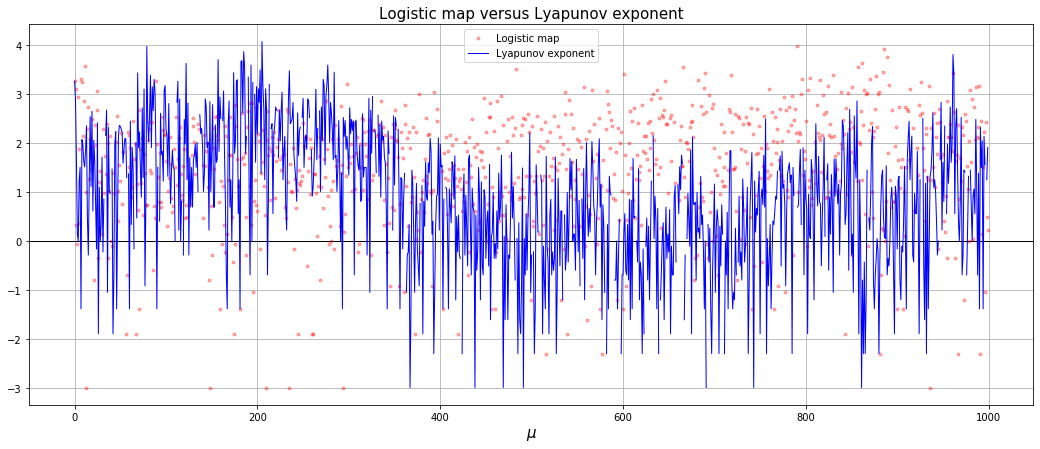

In [91]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)

ax1.axhline(y=0, linewidth=1, color='k')
ax1.plot(xticks, result[:1000],'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(xticks, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
plt.show()

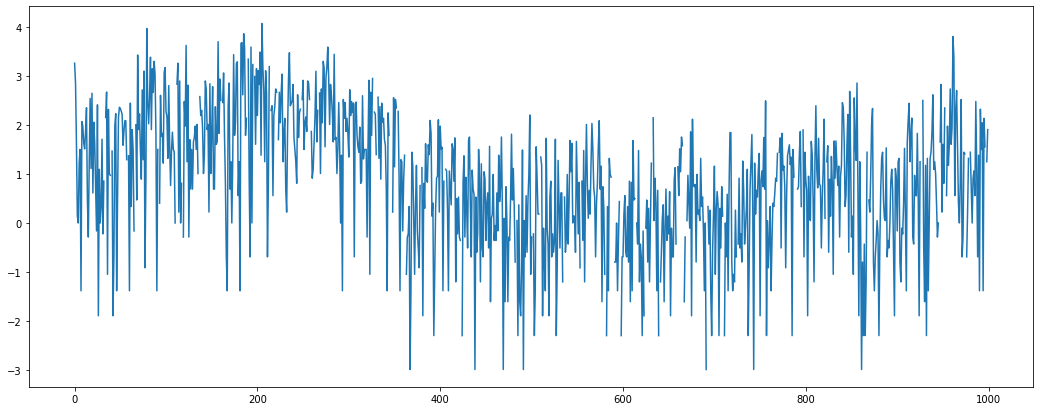

In [63]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(s)
plt.show()

In [129]:
num_points = num_steps
result = []
lambdas = []
maps = []
xmin, xmax = 3, 4
mult = (xmax - xmin) * num_points
mult

10000

In [130]:
mu_values = np.arange(xmin, xmax, 20/num_points)

In [131]:
for r in mu_values:
    x = series[0,0]
    result = []
    for t in range(100):
        x = r * x * (1 - x)
        result.append(np.log(abs(r - 2*r*x)))
    lambdas.append(np.mean(result))
    # Ignore first 100 iterates.
    for t in range(20):
        x = r * x * (1 - x)
        maps.append(x)

/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


In [152]:
x = series[0,0]
for _ in range(10):
    x = r * x * (1 - x)
    print(x)

-7703986.769654789
-237286976564302.66
-2.251078267696124e+29
-2.025927876243998e+59
-1.6409326271450126e+119
-1.076525422754218e+239
-inf
-inf
-inf
-inf


/Users/rodney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


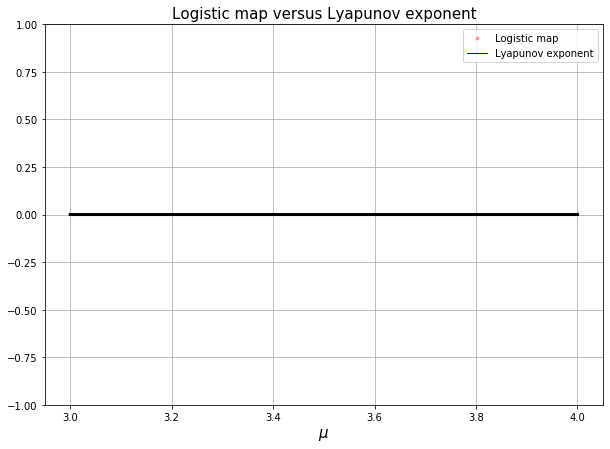

In [132]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,1,1)

xticks = np.linspace(xmin, xmax, mult)
zero = [0] * mult
ax1.plot(xticks, zero, 'k-', linewidth=3)
ax1.plot(xticks, maps,'r.', alpha = 0.3, label='Logistic map')
ax1.set_xlabel('r')
ax1.plot(mu_values, lambdas, 'b-', linewidth=1, label='Lyapunov exponent')
ax1.grid('on')
ax1.set_ylim(-1, 1)
ax1.set_xlabel('$\mu$', fontsize=15)
ax1.legend(loc='best')
ax1.set_title('Logistic map versus Lyapunov exponent', fontsize=15)

plt.show()